In [2]:
import pandas as pd
import numpy as np
import pickle as pkl

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OrdinalEncoder

from BiasScan.MDSS import *

import matplotlib.pyplot as plt
%matplotlib notebook

from tqdm import tqdm
from collections import OrderedDict
from multiprocessing.pool import Pool
from multiprocessing import cpu_count
import time

In [3]:
!pwd

/Users/victorakinwande/Documents/Development/PosivityViolation/KDD_BiasScan


### Load Dataset

In [4]:
covariates = ["age", "workclass", "education", "marital-status", "occupation", 
              "race", "sex", "hours-per-week"]
outcome = "outcome"


# data containing categorical features
mdscan_data = pd.read_csv("datasets/adult/test.data")
mdscan_data["outcome"] = (mdscan_data["outcome"] == " >50K.").astype(np.int)

### Define Classifiers

In [5]:
classifiers_labels = [
    "LogisticRegression",
    "RandomForestClassifier",
    "SVC",
    "KNeighborsClassifier",
    "MLPClassifier"
]

In [4]:
domains = {}

for cov in covariates:
    domains[cov] = np.unique(mdscan_data[cov])
    
observed = 'outcome'
expected = 'proba' 

In [5]:
NUM_RESTARTS = 5
NUM_EXPERIMENTS = 10
PENALTY = 0.
DIRECTION = 'positive'

### Test 1

In [ ]:
def experiment1(p, i, seed):
    np.random.seed(seed)
    
    mdscan_data_local = mdscan_data.copy()
    results = {}
    
    # define scanner
    scanner = MDSS(
        optim_q_mle=bisection_q_mle,
        solver_q_min=bisection_q_min,
        solver_q_max=bisection_q_max,
    )
    
    for clf_label in classifiers_labels:
        # load probability column for the current experiment
        filename = "training/test1/clf=%s_p=%d_i=%d.pkl" % (clf_label, p, i)
        file = open(filename, 'rb')
        proba = pkl.load(file)
        file.close()
        
        # add probability column
        mdscan_data_local["proba"] = proba

        # run MDSS
        subset, score = scanner.run_bias_scan(  
            coordinates=mdscan_data_local[covariates],
            probs=mdscan_data_local['proba'], 
            outcomes=mdscan_data_local['outcome'],
            penalty=PENALTY, 
            num_iters=NUM_RESTARTS, 
            direction=DIRECTION,
            num_threads=1
        )
        results[clf_label] = score
        
    return results

In [8]:
percentages = [1, 2, 4, 8, 16, 32]

In [ ]:
num_experiments = NUM_EXPERIMENTS
results = {}
acc = {}

# start time
start = time.time()

# define thread pool
pool = Pool(processes=cpu_count() - 1)

for p in percentages:
    results[p] = {}
    acc[p] = []
    seeds = np.random.randint(0, 99999, size=num_experiments)
    
    for i in range(num_experiments):
        acc[p].append(pool.apply_async(experiment1, (p, i, seeds[i])))
        
# close thread pool & wait for all jobs to be done
pool.close()
pool.join()

for p in percentages:
    # collect the results
    acc[p] = [res.get() for res in acc[p]]
    
    for clf_label in classifiers_labels:
        for res in acc[p]:
            results[p][clf_label] = results[p].get(clf_label, []) + [res[clf_label]]
            
# print duration
print("Ellapsed: %.2f" % (time.time() - start))

In [ ]:
# save results
file = open("./results/bias_test1.pkl", 'wb')
pkl.dump(results, file)
file.close()

In [9]:
results = pkl.load(open("./results/bias_test1.pkl", 'rb'))
statistics = {}

for p in results:
    for clf in classifiers_labels:
        scores = results[p][clf]
        mean_score = np.mean(scores)
        stdev_score = np.std(scores)
        statistics[clf] = statistics.get(clf, []) + [[mean_score, stdev_score]]

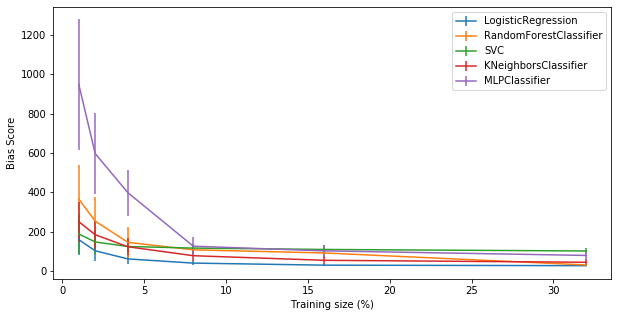

In [10]:
plt.figure(figsize=(10, 5))

for clf in classifiers_labels:
    y = np.array(statistics[clf])
    plt.errorbar(percentages, y[:, 0], yerr=y[:, 1])

plt.legend(classifiers_labels)
plt.xlabel("Training size (%)")
plt.ylabel("Bias Score")
plt.show()

### Test 2

In [ ]:
def experiment2(nc, i, seed):
    np.random.seed(seed)
    
    results = {}
    mdscan_data_local = mdscan_data.copy()
    
    # define scanner
    scanner = MDSS(
        optim_q_mle=bisection_q_mle,
        solver_q_min=bisection_q_min,
        solver_q_max=bisection_q_max,
    )
    
    for clf_label in classifiers_labels:
        # load probability column for the current experiment
        filename = "./training/test2/clf=%s_nc=%d_i=%d.pkl" % (clf_label, nc, i)
        file = open(filename, 'rb')
        proba = pkl.load(file)
        file.close()
        
        # add probability column
        mdscan_data_local["proba"] = proba

        # run MDSS
        subset, score = scanner.run_bias_scan(
            coordinates=mdscan_data_local[covariates],
            probs=mdscan_data_local['proba'], 
            outcomes=mdscan_data_local['outcome'],
            penalty=PENALTY, 
            num_iters=NUM_RESTARTS, 
            direction=DIRECTION,
            num_threads=1
        )
        results[clf_label] = score
        
    return results

In [11]:
num_covariates = [1, 2, 3, 4, 5]

In [ ]:
num_experiments = NUM_EXPERIMENTS
results = {}
acc = {}

# start time
start = time.time()

# define thread pool
pool = Pool(processes=cpu_count() - 1)

for nc in num_covariates:
    results[nc] = {}    
    acc[nc] = []
    seeds = np.random.randint(0, 99999, size=num_experiments)
    
    for i in range(num_experiments):
        acc[nc].append(pool.apply_async(experiment2, (nc, i, seeds[i])))
        
# close thread pool & wait for all jobs to be done
pool.close()
pool.join()

for nc in num_covariates:
    # collect the results
    acc[nc] = [res.get() for res in acc[nc]]
    
    for clf_label in classifiers_labels:
        for res in acc[nc]:
            results[nc][clf_label] = results[nc].get(clf_label, []) + [res[clf_label]]
            
# print duration
print("Ellapsed: %.2f" % (time.time() - start))

In [ ]:
# save results
file = open("./results/bias_test2.pkl", 'wb')
pkl.dump(results, file)
file.close()

In [12]:
results = pkl.load(open("./results/bias_test2.pkl", 'rb'))
statistics = {}

for nc in results:
    for clf in classifiers_labels:
        scores = results[nc][clf]
        mean_score = np.mean(scores)
        stdev_score = np.std(scores)
        
        buffer = statistics.get(clf, [])
        statistics[clf] = buffer + [[mean_score, stdev_score]]

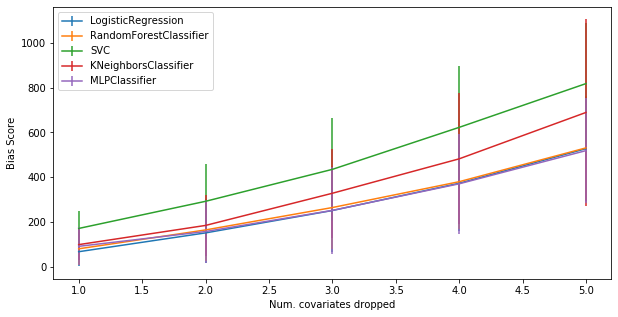

In [13]:
plt.figure(figsize=(10, 5))

for clf in classifiers_labels:
    y = np.array(statistics[clf])
    plt.errorbar(num_covariates, y[:, 0], yerr=y[:, 1])

plt.legend(classifiers_labels)
plt.xlabel("Num. covariates dropped")
plt.ylabel("Bias Score")
plt.show()

### Utils

In [ ]:
def get_subpopulation(df: pd.DataFrame, covariates: dict) -> pd.DataFrame:
    """
    Function that returns the sub-population according to the attributes dictionary passed as argument.
    Ex: {gender: [male, female], race: [white, black]}. Returns a data frame containing all rows containing
    a male or a female which is black or white.

    @param df: population
    @param covariates: dictionary where keys are attributes and values are lists of values
    corresponding to that attribute.
    :return: restricted sub-population imposed by attributes
    """
    # check if dictionary is empty
    if not covariates:
        return df

    mask = np.ones(df.shape[0], dtype=np.bool)
    for covariate in covariates:
        mask &= np.isin(df[covariate].to_numpy(), covariates[covariate])

    return df[mask]

In [ ]:
def get_accuracy(df: pd.DataFrame, s_affected: dict, s_found: dict, ys_cname:str, ps_cname: str):
    """
    Compute accuracy given a sub-population, the affected sub-population
    and the sub-population reported by MDSS. Accuracy is computed as the intersection/union of the
    two sub-population, affected & found, for the current dataframe

    @param df: dataframe sub-population (treatment sub-population)
    @param s_affected: sub-population affected
    @param s_found: sub-population reported by MDSS
    @param ys_cname: outcome column name
    @param ps_cname: probability column name
    :return: accuracy
    """
    # select affected & found sub-population
    df_affected = get_subpopulation(df, s_affected)
    df_found = get_subpopulation(df, s_found)

    df_affected = df_affected.drop([ys_cname, ps_cname], "columns").to_numpy()
    df_found = df_found.drop([ys_cname, ps_cname], "columns").to_numpy()

    # transform in sets
    set_affected = set([tuple(x) for x in list(df_affected)])
    set_found = set([tuple(x) for x in list(df_found)])

    # compute intersection and union
    len_intersection = len(set_affected.intersection(set_found))
    len_union = len(set_affected.union(set_found))

    return len_intersection / len_union

### Test 3

In [ ]:
def experiment3(p, i, seed):
    np.random.randint(seed)
    
    mdscan_data_local = mdscan_data.copy()
    results = {}
    
    # define scanner
    scanner = MDSS(
        optim_q_mle=bisection_q_mle,
        solver_q_min=bisection_q_min,
        solver_q_max=bisection_q_max,
    )

    for clf_label in classifiers_labels:
        # load probability column for the current experiment
        filename = "./training/test3/clf=%s_p=%d_i=%d.pkl" % (clf_label, p, i)
        file = open(filename, 'rb')
        proba = pkl.load(file)
        file.close()
        
        # add probability column
        mdscan_data_local["proba"] = proba

        # run MDSS
        subset, score = scanner.run_bias_scan(
            coordinates=mdscan_data_local[covariates],
            probs=mdscan_data_local['proba'], 
            outcomes=mdscan_data_local['outcome'],
            penalty=PENALTY, 
            num_iters=NUM_RESTARTS, 
            direction=DIRECTION,
            num_threads=1
        )
        results[clf_label] = score
    
    return results

In [14]:
percentages = [1, 2, 4, 8, 16, 32]

In [ ]:
num_experiments = NUM_EXPERIMENTS
results = {}
acc = {}

# transform categorical variables into dummy
train_data = pd.get_dummies(mdscan_data, prefix=covariates, columns=covariates)

# start time
start = time.time()

# define thread pool
pool = Pool(processes=cpu_count() - 1)

for p in percentages:
    results[p] = {}    
    acc[p] = []
    seeds = np.random.randint(0, 99999, size=num_experiments)
    
    for i in range(num_experiments):
        acc[p].append(pool.apply_async(experiment3, (p, i, seeds[i])))
        
# close thread pool & wait for all jobs to be done
pool.close()
pool.join()

for p in percentages:
    # collect the results
    acc[p] = [res.get() for res in acc[p]]
    
    for clf_label in classifiers_labels:
        for res in acc[p]:
            results[p][clf_label] = results[p].get(clf_label, []) + [res[clf_label]]
            
# print duration
print("Ellapsed: %.2f" % (time.time() - start))

In [ ]:
# save results
file = open("./results/bias_test3.pkl", 'wb')
pkl.dump(results, file)
file.close()

In [15]:
results = pkl.load(open("./results/bias_test3.pkl", 'rb'))
statistics = {}

for p in results:
    for clf in classifiers_labels:
        scores = results[p][clf]
        mean_score = np.mean(scores)
        stdev_score = np.std(scores)
        
        buffer = statistics.get(clf, [])
        statistics[clf] = buffer + [[mean_score, stdev_score]]

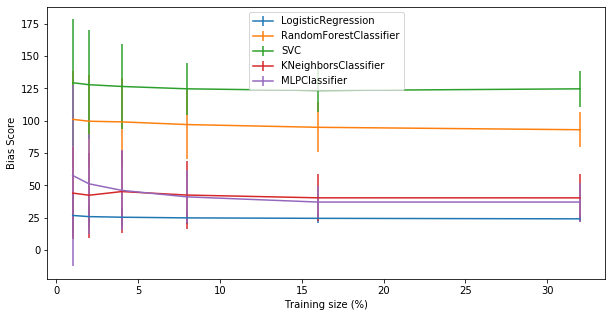

In [16]:
plt.figure(figsize=(10, 5))

for clf in classifiers_labels:
    y = np.array(statistics[clf])
    plt.errorbar(percentages, y[:, 0], yerr=y[:, 1])

plt.legend(classifiers_labels)
plt.xlabel("Training size (%)")
plt.ylabel("Bias Score")
plt.show()

### Test 4

In [ ]:
def experiment4(q, i, seed):
    np.random.seed(seed)

    score_results = {}
    accuracy_results = {}
    mdscan_data_local = mdscan_data.copy()
    
    # define scanner
    scanner = MDSS(
        optim_q_mle=bisection_q_mle,
        solver_q_min=bisection_q_min,
        solver_q_max=bisection_q_max,
    )
    
    for clf_label in classifiers_labels:
        # load outcome, probability and affected sub-population for the current experiment
        filename = "./training/test4/clf=%s_q=%.2f_i=%d.pkl" % (clf_label, q, i)
        file = open(filename, 'rb')
        proba, s_affected = pkl.load(file)
        file.close()
        
        # add probability column
        mdscan_data_local["proba"] = proba

        # run MDSS
        subset, score = scanner.run_bias_scan(
            coordinates=mdscan_data_local[covariates],
            probs=mdscan_data_local['proba'], 
            outcomes=mdscan_data_local['outcome'],
            penalty=PENALTY, 
            num_iters=NUM_RESTARTS, 
            direction=DIRECTION,
            num_threads=1
        )
        accuracy = get_accuracy(mdscan_data_local, s_affected=s_affected, s_found=subset,
                               ys_cname="outcome", ps_cname="proba")

        # buffer score for the current clssifier
        score_results[clf_label] = score
        accuracy_results[clf_label] = accuracy
        
    return score_results, accuracy_results

In [17]:
qs = [.9, .7, .5, .3, .1]

In [ ]:
num_experiments = NUM_EXPERIMENTS
score_results = {}
accuracy_results = {}
acc = {}

# transform categorical variables into dummy
train_data = pd.get_dummies(mdscan_data, prefix=covariates, columns=covariates)

# start time
start = time.time()

# define thread pool
pool = Pool(processes=cpu_count() - 1)
    
for q in qs:
    score_results[q] = {}
    accuracy_results[q] = {}   
    acc[q] = []
    seeds = np.random.randint(0, 99999, size=num_experiments)
    
    for i in range(num_experiments):
        acc[q].append(pool.apply_async(experiment4, (q, i, seeds[i])))
        
# close thread pool & wait for all jobs to be done
pool.close()
pool.join()


for q in qs:
    # collect the results
    score_acc = [res.get()[0] for res in acc[q]]
    accuracy_acc = [res.get()[1] for res in acc[q]]
    
    for clf_label in classifiers_labels:
        for score_res in score_acc:
            score_results[q][clf_label] = score_results[q].get(clf_label, []) + [score_res[clf_label]]
        
        for accuracy_res in accuracy_acc:
            accuracy_results[q][clf_label] = accuracy_results[q].get(clf_label, []) + [accuracy_res[clf_label]]

# print duration
print("Ellapsed: %.2f" % (time.time() - start))

In [ ]:
# save results
file = open("./results/bias_test4_score.pkl", 'wb')
pkl.dump(score_results, file)
file.close()

In [18]:
score_results = pkl.load(open("./results/bias_test4_score.pkl", 'rb'))
statistics = {}

for q in score_results:
    for clf in classifiers_labels:
        scores = score_results[q][clf]
        mean_score = np.mean(scores)
        stdev_score = np.std(scores)
        
        buffer = statistics.get(clf, [])
        statistics[clf] = buffer + [[mean_score, stdev_score]]

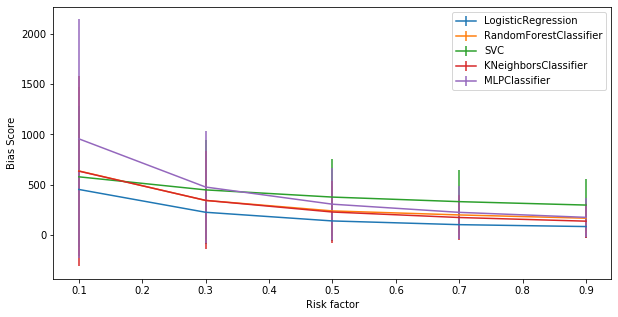

In [19]:
plt.figure(figsize=(10, 5))

for clf in classifiers_labels:
    y = np.array(statistics[clf])
    plt.errorbar(qs, y[:, 0], yerr=y[:, 1])

plt.legend(classifiers_labels)
plt.xlabel("Risk factor")
plt.ylabel("Bias Score")
plt.show()

In [ ]:
# save results
file = open("./results/bias_test4_accuracy.pkl", 'wb')
pkl.dump(accuracy_results, file)
file.close()

In [20]:
accuracy_results = pkl.load(open("./results/bias_test4_accuracy.pkl", 'rb'))
statistics = {}

for q in accuracy_results:
    for clf in classifiers_labels:
        accuracies = accuracy_results[q][clf]
        mean_accuracy = np.mean(accuracies)
        stdev_accuracy = np.std(accuracies)
        
        buffer = statistics.get(clf, [])
        statistics[clf] = buffer + [[mean_accuracy, stdev_accuracy]]

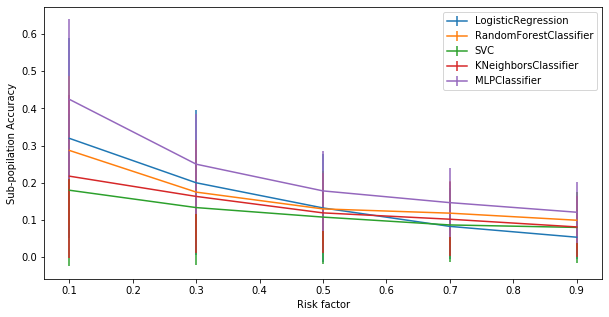

In [21]:
plt.figure(figsize=(10, 5))

for clf in classifiers_labels:
    y = np.array(statistics[clf])
    plt.errorbar(qs, y[:, 0], yerr=y[:, 1])

plt.legend(classifiers_labels)
plt.xlabel("Risk factor")
plt.ylabel("Sub-popilation Accuracy")
plt.show()

### Test 5

In [ ]:
def experiment5(cov, i, seed):
    np.random.seed(seed)
    
    results = {}
    mdscan_data_local = mdscan_data.copy()
    
    # define scanner
    scanner = MDSS(
        optim_q_mle=bisection_q_mle,
        solver_q_min=bisection_q_min,
        solver_q_max=bisection_q_max,
    )
    
    for clf_label in classifiers_labels:
        # load probability column
        filename = "./training/test5/clf=%s_cov=%s_i=%d.pkl" % (clf_label, cov, i)
        file = open(filename, 'rb')
        proba = pkl.load(file)
        file.close()
        
        # add probability column
        mdscan_data_local["proba"] = proba

        # run MDSS
        subset, score = scanner.run_bias_scan(
            coordinates=mdscan_data_local[covariates],
            probs=mdscan_data_local['proba'], 
            outcomes=mdscan_data_local['outcome'],
            penalty=PENALTY, 
            num_iters=NUM_RESTARTS, 
            direction=DIRECTION,
            num_threads=1
        )

        # buffer score for the current clssifier
        results[clf_label] = score

    return results

In [ ]:
num_experiments = NUM_EXPERIMENTS
num_rows = mdscan_data.shape[0]
results = {}
acc = {}

# start time
start = time.time()

# define thread pool
pool = Pool(processes=cpu_count() - 1)

extended_cov = [None] + covariates
for cov in extended_cov:
    results[cov] = {}
    seeds = np.random.randint(0, 99999, size=num_experiments)
    acc[cov] = []
    
    for i in range(num_experiments):
        acc[cov].append(pool.apply_async(experiment5, (cov, i, seeds[i])))
        
# close thread pool & wait for all jobs to be done
pool.close()
pool.join()

for cov in extended_cov:
    # collect the results
    acc[cov] = [res.get() for res in acc[cov]]
    
    for clf_label in classifiers_labels:
        for res in acc[cov]:
            results[cov][clf_label] = results[cov].get(clf_label, []) + [res[clf_label]]
            
# print duration
print("Ellapsed: %.2f" % (time.time() - start))

In [ ]:
# save results
file = open("./results/bias_test5.pkl", 'wb')
pkl.dump(results, file)
file.close()

In [22]:
results = pkl.load(open("./results/bias_test5.pkl", 'rb'))
statistics = {}
extended_cov = [None] + covariates

for clf in classifiers_labels:
    statistics[clf] = []
    
    for cov in extended_cov:
        statistics[clf].append(np.mean(results[cov][clf]))

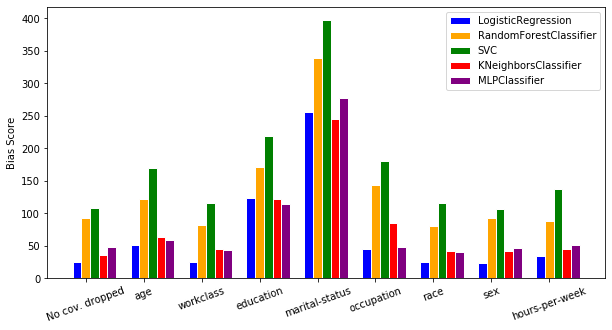

In [23]:
# set width of bar
bar_width = 0.15
 
rs = [np.arange(len(extended_cov))]
for i in range(1, len(classifiers_labels)):
    r = np.array([x + bar_width for x in rs[i - 1]])
    rs.append(r)

colors = ['blue', 'orange', 'green', 'red', 'purple']

plt.figure(figsize=(10, 5))
# Make the plot
for idx, clf in enumerate(classifiers_labels):
    plt.bar(rs[idx], statistics[clf], color=colors[idx], width=bar_width, edgecolor='white', label=clf)

extended_cov[0] = 'No cov. dropped'
plt.ylabel('Bias Score')
plt.xticks([r + bar_width for r in range(len(rs[0]))], extended_cov, rotation=20)
 
# Create legend & Show graphic
plt.legend()
plt.show()

In [24]:
table = pd.DataFrame(statistics, index=extended_cov)
table

,LogisticRegression,RandomForestClassifier,SVC,KNeighborsClassifier,MLPClassifier
No cov. dropped,24.924921,93.125541,108.791722,36.047028,48.053984
age,51.967192,121.776789,169.717269,63.962345,59.548440
workclass,24.853007,82.627745,115.972774,44.751360,43.838014
education,123.210251,172.108663,218.926301,122.199710,114.013197
marital-status,255.301469,339.005962,398.136733,245.796175,277.680445
occupation,45.874392,144.133992,181.103697,85.244199,48.695131
race,25.763164,80.879933,115.760085,41.806783,39.854905
sex,23.232279,93.624925,107.417215,41.803297,46.368419
hours-per-week,34.124566,87.796881,137.414898,45.738588,50.772694
